# Resolving the whole process of plant essential oil dataset
## Load the required packages 

In [1]:
import torch
import seaborn
seaborn.set_context(context="talk")
from GCMSFormer.GCMSFormer import train_model, evaluate_model, check_model, plot_loss, make_model
from GCMSFormer.da import gen_datasets
import pickle
from GCMSFormer.Resolution import Resolution, output_msp
from GCMSFormer.Alignment import Alignment
import time
import os
from GCMSFormer.NetCDF import netcdf_reader  
import pandas as pd

## Load the Library

In [2]:
with open('Library/tgt_vacob.pk', 'rb') as file_1:
     tgt_vacob = pickle.load(file_1)

## Load GCMSFormer model 

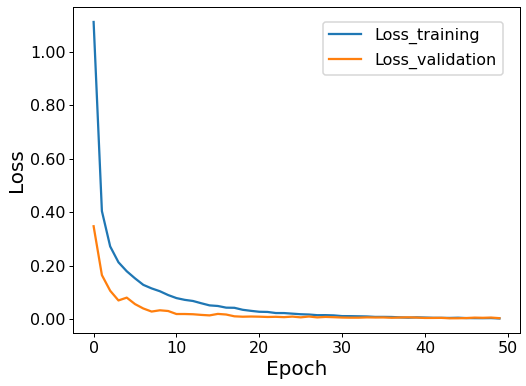

In [3]:
model_path='../model'
model_name='GCMSFormer'
loss_name='loss'
mz_range = (1, 1000)
if check_model(model_path + '/' + model_name, model_path + '/' + loss_name):
    # load model
    m_state_dict = torch.load(model_path + '/' + model_name + '.pt')
    model = make_model(len(tgt_vacob), N=6, 
                   d_model=1000, d_ff=1024, h=5, dropout=0.1)
    model.load_state_dict(m_state_dict)
    # load loss
    with open(model_path + '/' + loss_name +'.pk', 'rb') as file_1:
         loss = pickle.load(file_1)
    plot_loss(loss)
else:
    para = {'name': 'Library/spectra.msp',
                    'mz_range': mz_range,
                    'aug_num': 30000,
                    'layer_num': 6,
                    'batch': 20,
                    'epoch': 50,
                    'lr': 0.0001,
                    'head': 5,
                    'model_path': '../model',
                    'model_name': model_name,
                    'loss_name': loss_name}
    # Generating Dataset
    TRAIN, VALID, TEST, tgt_vacob = gen_datasets(para)
    # Train model
    model, Loss = train_model(para,TRAIN, VALID, tgt_vacob)
    plot_loss(Loss) 
    # Test model
    score=evaluate_model(model,TEST,tgt_vacob,int(max(para['mz_range'])))

## GCMSFormer resolution of plant essential oil datasets

In [4]:
# Test GCMSFormer
devices = torch.device('cpu')
model = model.to(devices)
start = time.time()
path = '../data'
files = os.listdir(path)
Alignment_or_not = True
if Alignment_or_not:
    # Set Ⅰ
    df0, N0 = Alignment(path,files[0:5],model,tgt_vacob.to(devices),devices)
    df0.to_csv(path + '/' + 'SetⅠ.csv', index=False)
    # Set Ⅱ
    df1, N1 = Alignment(path,files[5:10],model,tgt_vacob.to(devices),devices)
    df1.to_csv(path + '/' + 'SetⅡ.csv', index=False)
else:
    for filename in files:
            ncr = netcdf_reader(path + '/' + filename, True)
            sta_S, area, rt, R2 = Resolution(path,filename,model,tgt_vacob.to(devices),devices)
            msp = filename.split('.CDF')[0] + '.MSP'
            output_msp(path + '/'+ msp, sta_S, rt)
            csv = filename.split('.CDF')[0] + '.csv'
            df = pd.DataFrame({'rt': rt, 'area': area, 'R2': R2})
            df.to_csv(path + '/' + csv, index = False)
end = time.time()
print("Running time: %.2fs"%(end - start))

2-1.0.CDF: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:22<00:00,  1.66it/s]


Running time: 210.67s
